In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
import seaborn as sns

plt.style.use('ggplot')

In [12]:
def cliffsDelta(lst1, lst2, **dull):
    """Returns delta and true if there are more than 'dull' differences"""
    if not dull:
        dull = {'small': 0.147, 'medium': 0.33, 'large': 0.474} # effect sizes from (Hess and Kromrey, 2004)
    m, n = len(lst1), len(lst2)
    lst2 = sorted(lst2)
    j = more = less = 0
    for repeats, x in runs(sorted(lst1)):
        while j <= (n - 1) and lst2[j] < x:
            j += 1
        more += j*repeats
        while j <= (n - 1) and lst2[j] == x:
            j += 1
        less += (n - j)*repeats
    d = (more - less) / (m*n)
    size = lookup_size(d, dull)
    return d #, size                  # Закоментировал возвращение дискретного значения размера эффекта,
                                      # чтобы без проблем использовать bootstrap 

def lookup_size(delta: float, dull: dict) -> str:
    """
    :type delta: float
    :type dull: dict, a dictionary of small, medium, large thresholds.
    """
    delta = abs(delta)
    if delta < dull['small']:
        return 'negligible'
    if dull['small'] <= delta < dull['medium']:
        return 'small'
    if dull['medium'] <= delta < dull['large']:
        return 'medium'
    if delta >= dull['large']:
        return 'large'

def runs(lst):
    """Iterator, chunks repeated values"""
    for j, two in enumerate(lst):
        if j == 0:
            one, i = two, 0
        if one != two:
            yield j - i, one
            i = j
        one = two
    yield j - i + 1, two
    
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95, # уровень значимости
    N = 1,
    concat = True,
    plot_flag = False,
    colname = ''
):
    if (concat):
        boot_len_1 = len(data_column_1)
        boot_len_2 = len(data_column_2)
        data_for_sample_1 = pd.Series(np.concatenate((data_column_1, data_column_2), axis=None))
        data_for_sample_2 = pd.Series(np.concatenate((data_column_1, data_column_2), axis=None))
        const = statistic(data_column_1) - statistic(data_column_2)
    else:
        boot_len_1 = max([len(data_column_1), len(data_column_2)])
        boot_len_2 = max([len(data_column_1), len(data_column_2)])
        data_for_sample_1 = data_column_1
        data_for_sample_2 = data_column_2
        const = 0
        
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_for_sample_1.sample(
            boot_len_1, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_for_sample_2.sample(
            boot_len_2,
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2)) 
    
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
    quants.columns = [str(statistic.__name__)]
    
    if (concat):
        p_value = norm.cdf(x = -np.abs(const), loc = np.mean(boot_data), scale = np.std(boot_data)) * 2
    else:
        p_1 = norm.cdf(x = 0, loc = np.mean(boot_data), scale = np.std(boot_data))
        p_2 = norm.cdf(x = 0, loc = -np.mean(boot_data), scale = np.std(boot_data))
        p_value = min(p_1, p_2) * 2
    
    if p_value > 1:
        p_value = 1
        
    # Визуализация
    
    if(plot_flag):
        sns.displot(x = pd_boot_data[0], kind = "kde", fill = True)
        plt.axvline(const, linestyle='-', color='black')
        plt.axvline(quants.values[0], linestyle='--', color='green')
        plt.axvline(quants.values[1], linestyle='--', color='green')
        plt.xlabel('Разность ' + str(statistic.__name__) + ' двух групп')

        plt.title("Histogram of " + colname)
        plt.savefig(f'plots/bootstrap/{colname}', bbox_inches='tight')
        plt.show()
        

    if (const >= quants.iloc[:, 0].iloc[0]) & (const <= quants.iloc[:, 0].iloc[1]):
        result = False
    else:
        if (p_value >= 0.01 / N):
            result = False
        else:
            result = True
            
    observed_difference = statistic(data_column_1) - statistic(data_column_2)
       
    return {"result": result,
            "observed_difference": observed_difference,
            "quants": quants,
            "p_value": p_value}

In [13]:
df = pd.read_csv('df2_total.csv', index_col=0)
cols = ['Асимметрия челюсти', 'Высота бровей', 'Наклон глаз',
       'Полнота верхней губы', 'Полнота нижней губы',
       'Асимметрия размера глаз', 'Ширина посадки глаз', 'Скулы',
       'Форма головы', 'Верхнее веко', 'Асимметрия брови', 'Наклон бровей',
       'Размер рта', 'Асимметрия наклона глаз', 'Асимметрия носа',
       'Размер глаз', 'Оттопыренность ушей', 'Ширина челюсти', 'Уголки рта',
       ]

for col in tqdm(cols):
    df[col] = (df[col] - df[col].quantile(0.01)) / (df[col].quantile(0.99) - df[col].quantile(0.001))
    
df['Категория'] = df['fraud'].replace({True: 'Мошенник', False: 'Не мошенник'})
cols = ['Асимметрия челюсти', 'Высота бровей', 'Наклон глаз',
       'Полнота верхней губы', 'Полнота нижней губы',
       'Асимметрия размера глаз', 'Ширина посадки глаз', 'Скулы',
       'Форма головы', 'Верхнее веко', 'Асимметрия брови', 'Наклон бровей',
       'Размер рта', 'Асимметрия наклона глаз', 'Асимметрия носа',
       'Размер глаз', 'Оттопыренность ушей', 'Ширина челюсти', 'Уголки рта',
       ]

/home/nikolay/anaconda3/envs/merlin/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3427: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


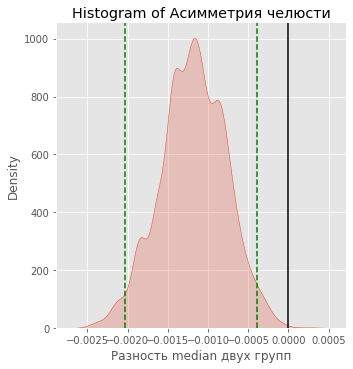

p_value:  0.0035845381937633456 Statistical value:  False


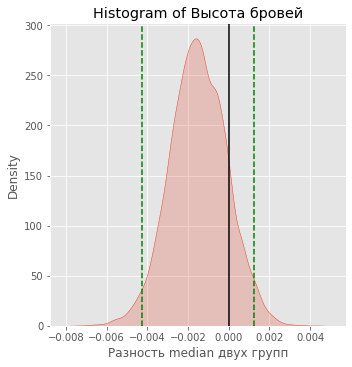

p_value:  0.28071020325083507 Statistical value:  False


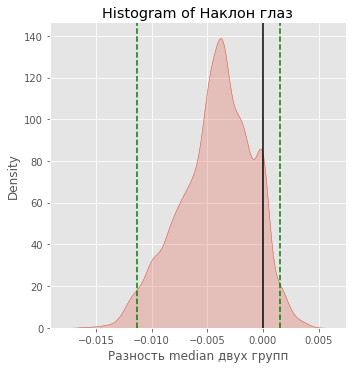

p_value:  0.1951393685849253 Statistical value:  False


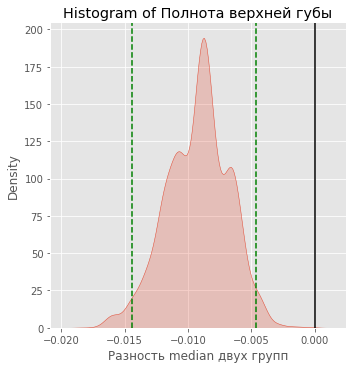

p_value:  0.0001986709470339834 Statistical value:  True


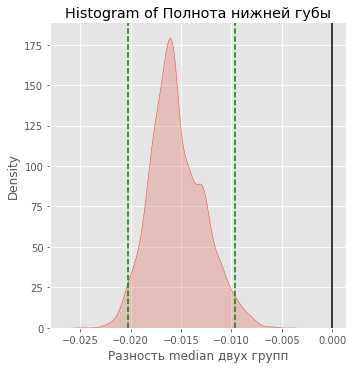

p_value:  7.209698468318759e-09 Statistical value:  True


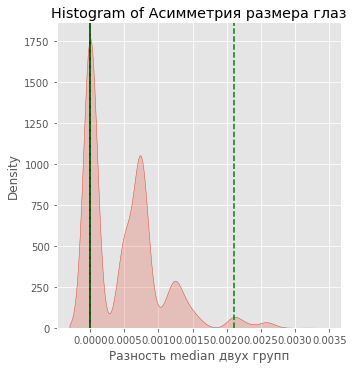

p_value:  0.372925070400863 Statistical value:  False


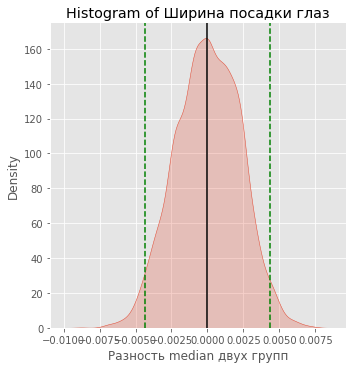

p_value:  0.9986681345681723 Statistical value:  False


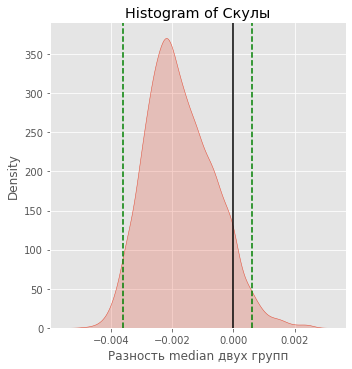

p_value:  0.12338003063872677 Statistical value:  False


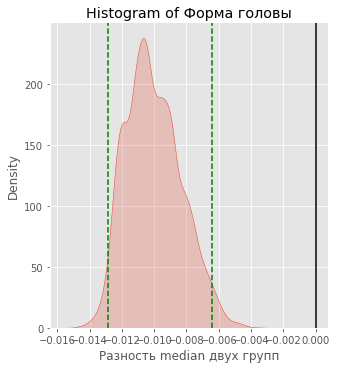

p_value:  3.9458764160807846e-09 Statistical value:  True


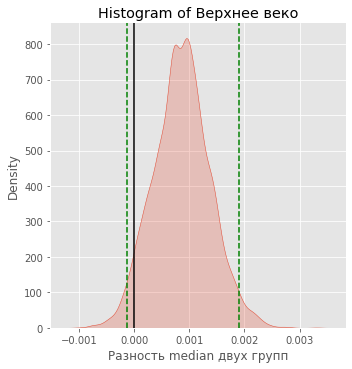

p_value:  0.09517552549419042 Statistical value:  False


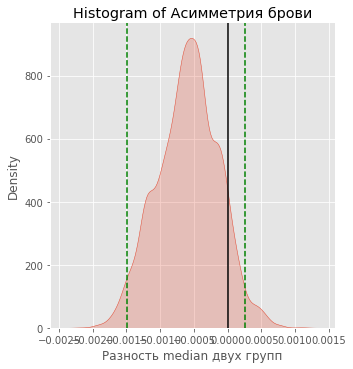

p_value:  0.19414676540681763 Statistical value:  False


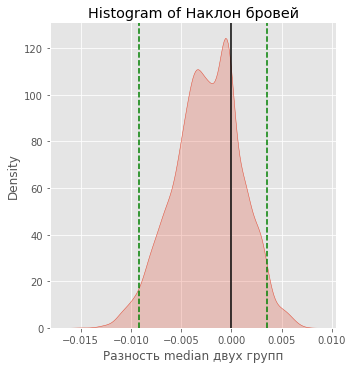

p_value:  0.470551510976991 Statistical value:  False


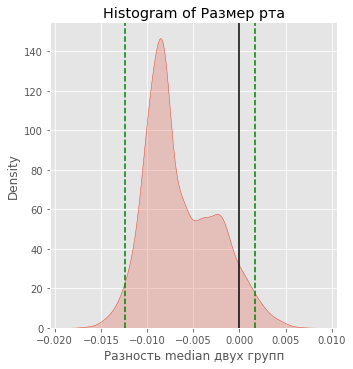

p_value:  0.09184365065833913 Statistical value:  False


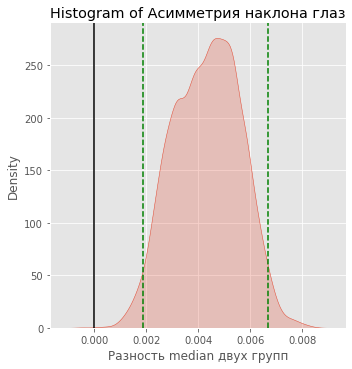

p_value:  0.0008169296538358668 Statistical value:  False


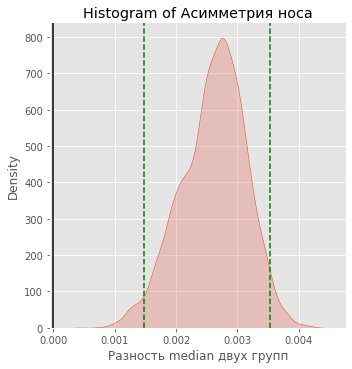

p_value:  8.327230039364181e-07 Statistical value:  True


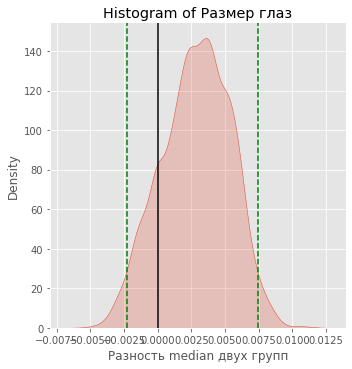

p_value:  0.272535681264522 Statistical value:  False


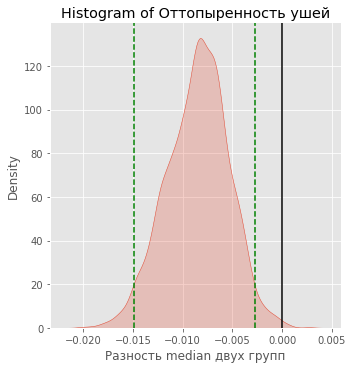

p_value:  0.006502691172703327 Statistical value:  False


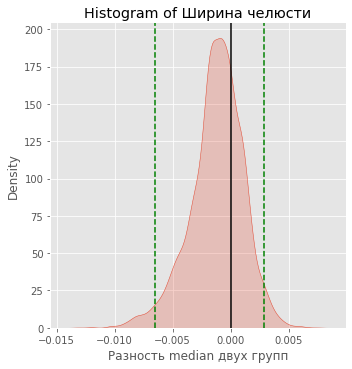

p_value:  0.5917685971090443 Statistical value:  False


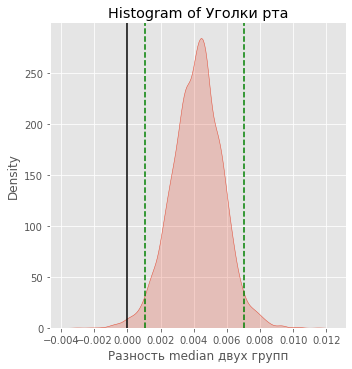

p_value:  0.0060608814864490145 Statistical value:  False


In [14]:
bad = df[df['Категория'] == 'Мошенник']
good = df[df['Категория'] == 'Не мошенник']

l_bot_quant = []
l_top_quant = []
l_observed_difference = []
l_p_value = []
l_result = []

s = np.median
n = 19 # Поправка на множественное сравнение (количество проверяемых гипотез)
for i in cols:
    res = get_bootstrap(
        bad[i], # числовые значения первой выборки
        good[i], # числовые значения второй выборки
        boot_it = 5000, # количество бутстрэп-подвыборок
        statistic = s, # интересующая нас статистика
        bootstrap_conf_level = 0.95,
        N = n,
        concat = False,
        plot_flag = True,
        colname = i)
    
    l_observed_difference.append(res['observed_difference'])
    l_p_value.append(res['p_value'])
    l_result.append(res['result'])
    l_bot_quant.append(res['quants'].iloc[:, 0].iloc[0])
    l_top_quant.append(res['quants'].iloc[:, 0].iloc[1])
    
    print("p_value: ", res['p_value'], \
          "Statistical value: ", res['p_value'] < (0.01 / 38))

In [15]:
res_boostrap = pd.DataFrame([cols, l_observed_difference, l_bot_quant, l_top_quant, l_p_value, l_result])
res_boostrap = res_boostrap.T
res_boostrap.columns = ['Feature', 'Медиана наблюдаемой разницы, %', 
                        'Нижняя граница доверительного интервала', 
                        'Верхняя граница доверительного интервала', 'p_value', 'Значимость']
res_boostrap['p_value'] = res_boostrap['p_value'].astype('float')
res_boostrap['Медиана наблюдаемой разницы, %'] = res_boostrap['Медиана наблюдаемой разницы, %']*100

res_boostrap.sort_values(by=['p_value'], ascending=False).reset_index(drop=True)

,Feature,"Медиана наблюдаемой разницы, %",Нижняя граница доверительного интервала,Верхняя граница доверительного интервала,p_value,Значимость
0,Ширина посадки глаз,0.049806,-0.004362,0.004312,9.986681e-01,False
1,Ширина челюсти,-0.101532,-0.006562,0.00287,5.917686e-01,False
2,Наклон бровей,-0.214495,-0.009231,0.003547,4.705515e-01,False
3,Асимметрия размера глаз,0.048508,0.0,0.0021,3.729251e-01,False
4,Высота бровей,-0.156171,-0.004268,0.00124,2.807102e-01,False
5,Размер глаз,0.341237,-0.002277,0.007479,2.725357e-01,False
6,Наклон глаз,-0.413333,-0.011334,0.001533,1.951394e-01,False
7,Асимметрия брови,-0.055884,-0.001491,0.000265,1.941468e-01,False
8,Скулы,-0.202861,-0.003591,0.000601,1.233800e-01,False
9,Верхнее веко,0.091062,-0.000139,0.001895,9.517553e-02,False
